# Cricket Shot Classification from Images

This notebook demonstrates the image-based cricket shot classification system developed in Sprint 2. It shows how to:

1. Extract pose data from cricket shot images using MediaPipe
2. Calculate joint angles and other biomechanical features from the pose data
3. Train a multiclass LSTM model to classify different cricket shots
4. Evaluate model performance
5. Make predictions on new images

In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import cv2
import torch
from pathlib import Path
from glob import glob
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Add the src directory to the path
sys.path.append('../')

# Import our modules
from src.data_collection.image_pose_extractor import ImagePoseExtractor
from src.feature_engineering.joint_angles import JointAngleCalculator
from src.feature_engineering.dataset_preparer import CricketShotDatasetPreparer
from src.model.multiclass_lstm_model import CricketShotClassifier, CricketShotLSTM

## 1. Configuration

First, let's set up the paths and load the configuration file.

In [2]:
# Set up paths - IMPORTANT: processed and raw dirs are OUTSIDE data directory
config_path = "../configs/config.yaml"
data_dir = "../data"
processed_dir = "../processed"  # Outside data directory
raw_dir = "../raw"              # Outside data directory
models_dir = "../models"
results_dir = "../results"

# Create directories if they don't exist
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Load configuration
import yaml

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully.")
print(f"Using {config['data']['pose']['model']} for pose estimation.")
print(f"Model type: {config['model']['type']}")
print(f"Sequence length: {config['model']['sequence_length']} frames")
print(f"Hidden units: {config['model']['hidden_units']}")
print(f"Batch size: {config['model']['batch_size']}")
print(f"Epochs: {config['model']['epochs']}")
print(f"Processed directory: {processed_dir}")
print(f"Raw directory: {raw_dir}")
print(f"Data directory: {data_dir}")

Configuration loaded successfully.
Using mediapipe for pose estimation.
Model type: lstm
Sequence length: 1 frames
Hidden units: 128
Batch size: 32
Epochs: 50
Processed directory: ../processed
Raw directory: ../raw
Data directory: ../data


## 2. Exploring the Dataset

Let's explore the image dataset organized by shot type.

Found 4 shot types: ['drive', 'legglance-flick', 'pullshot', 'sweep']
drive: 1223 images
legglance-flick: 1120 images
pullshot: 1260 images
sweep: 1120 images


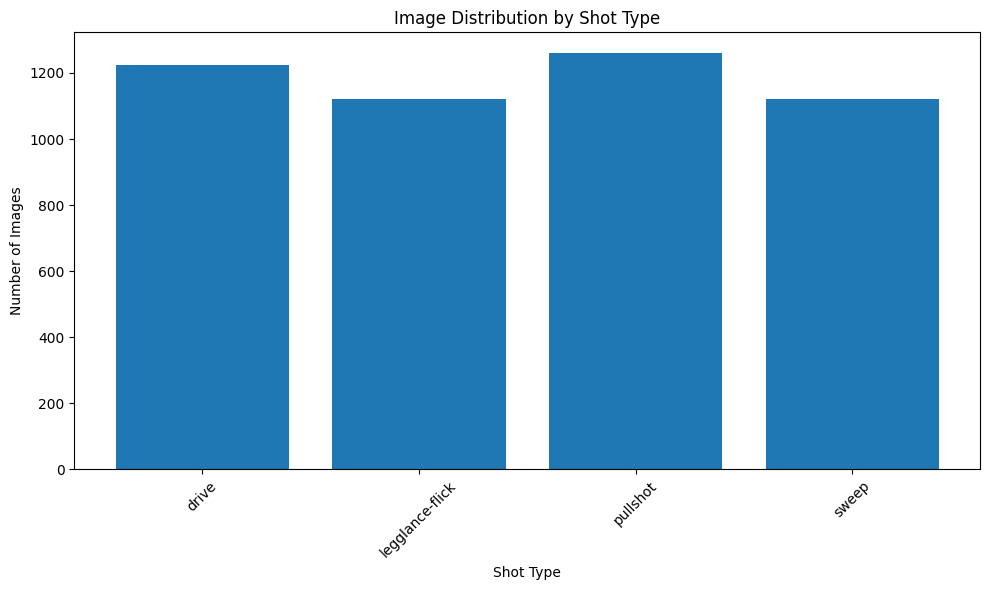

In [3]:
# Define the image data directory
image_data_dir = data_dir

# Get shot types (subdirectories)
shot_types = [d for d in os.listdir(image_data_dir) if os.path.isdir(os.path.join(image_data_dir, d))]

print(f"Found {len(shot_types)} shot types: {shot_types}")

# Count images per shot type
image_counts = {}
for shot_type in shot_types:
    shot_dir = os.path.join(image_data_dir, shot_type)
    image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
    image_counts[shot_type] = len(image_files)

# Display image counts
for shot_type, count in image_counts.items():
    print(f"{shot_type}: {count} images")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values())
plt.title('Image Distribution by Shot Type')
plt.xlabel('Shot Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's visualize a few sample images from each shot type.

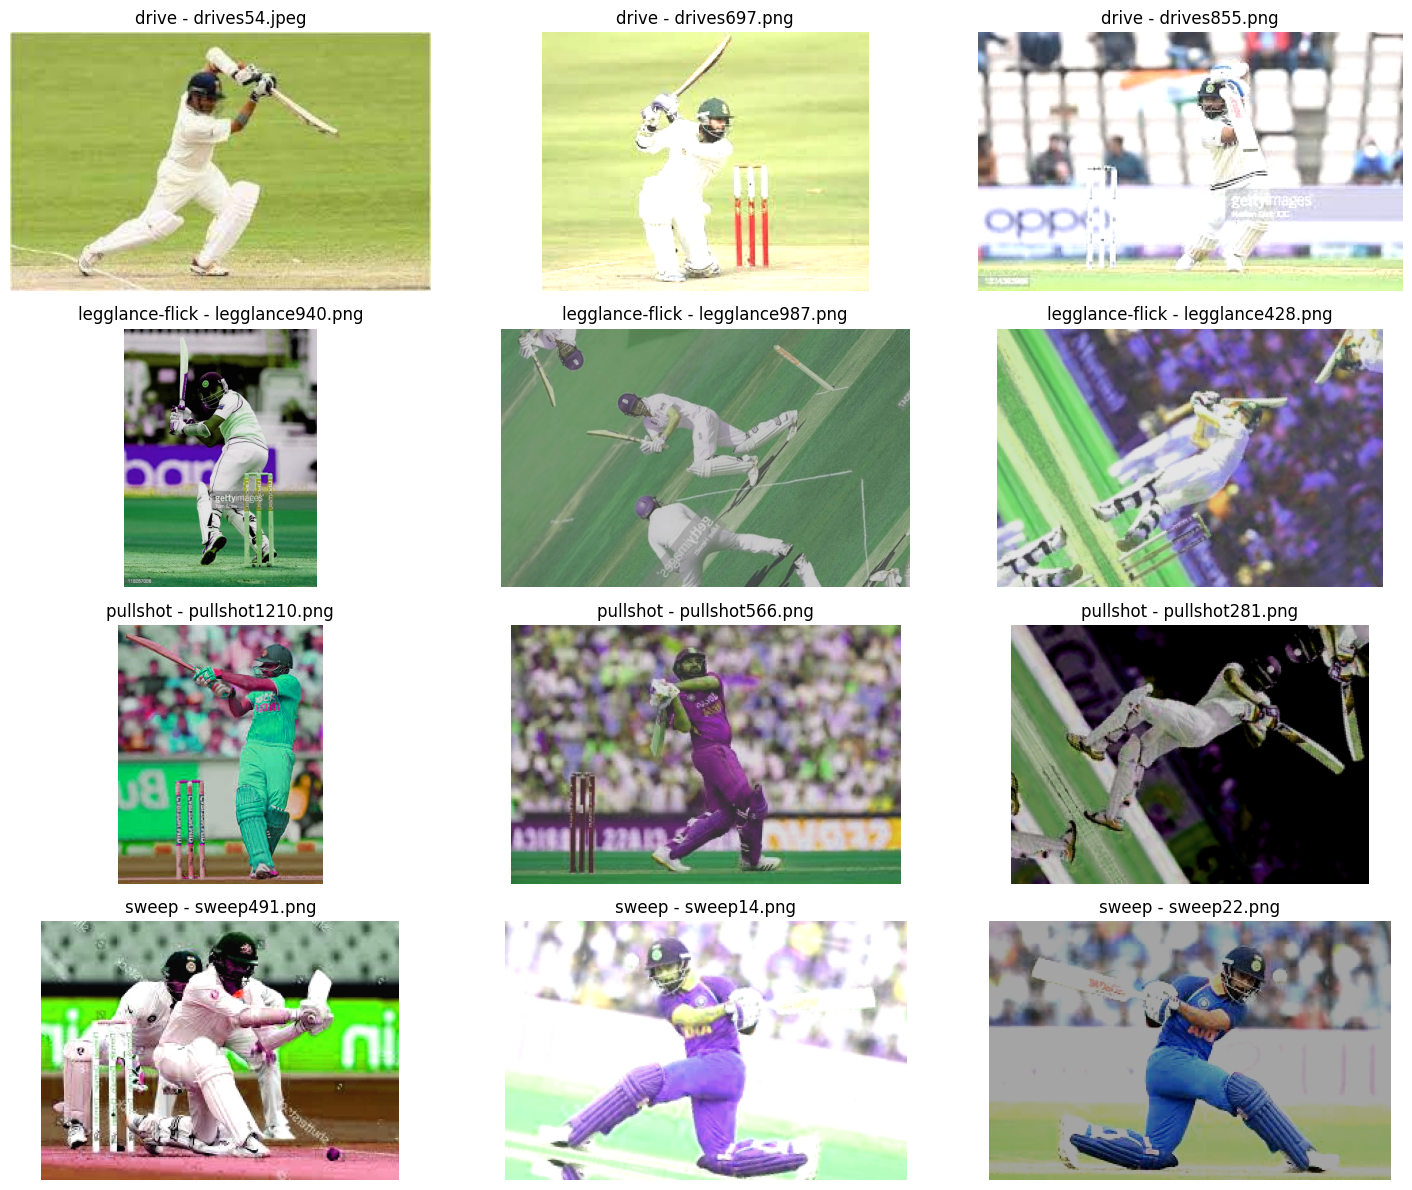

In [4]:
# Display sample images from each shot type
def display_sample_images(shot_types, samples_per_type=3):
    num_types = len(shot_types)
    fig, axes = plt.subplots(num_types, samples_per_type, figsize=(15, 3*num_types))
    
    if num_types == 1:
        axes = [axes]  # Make it 2D for consistent indexing
    
    for i, shot_type in enumerate(shot_types):
        shot_dir = os.path.join(image_data_dir, shot_type)
        image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
        
        # Select random samples
        if len(image_files) > samples_per_type:
            sample_files = np.random.choice(image_files, samples_per_type, replace=False)
        else:
            sample_files = image_files[:samples_per_type]
        
        for j, img_path in enumerate(sample_files):
            if j < samples_per_type:  # Ensure we don't exceed the number of columns
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i][j].imshow(img)
                axes[i][j].set_title(f"{shot_type} - {os.path.basename(img_path)}")
                axes[i][j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples
display_sample_images(shot_types)

## 3. Pose Extraction

Now, let's extract pose landmarks from the cricket shot images using MediaPipe.

✓ ImagePoseExtractor initialized successfully

Extracting pose from drive sample: drives1.png
Image loaded: (192, 262, 3)
RGB image shape: (192, 262, 3)
MediaPipe results: False
Visualization not found at ../processed\poses\visualizations\drives1_pose.jpg
No landmarks detected

Extracting pose from legglance-flick sample: legglance1.png
Image loaded: (648, 638, 3)
RGB image shape: (648, 638, 3)
MediaPipe results: True


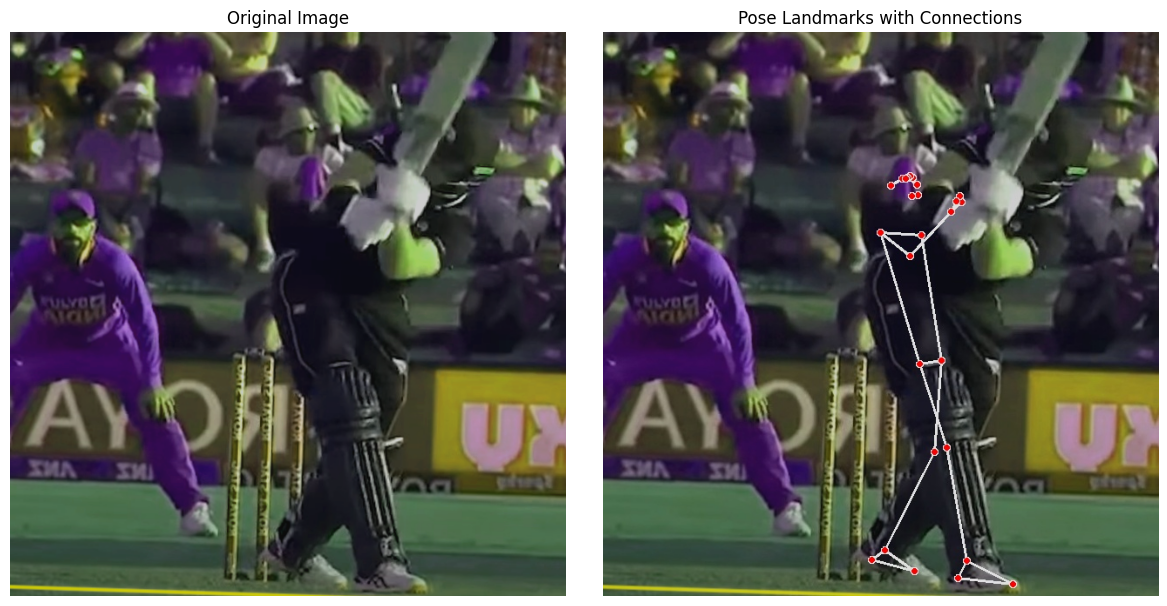

Detected 33 landmarks
MediaPipe detects 33 landmarks for full body pose estimation

Created 2 pose files for feature extraction.
Pose files stored in: ../processed\poses
NOT in data directory to avoid conflicts.


In [5]:
# Initialize the pose extractor
try:
    pose_extractor = ImagePoseExtractor(config_path)
    print("✓ ImagePoseExtractor initialized successfully")
except Exception as e:
    print(f"✗ Error initializing ImagePoseExtractor: {e}")
    print("Please install missing dependencies: pip install opencv-python mediapipe")
    print("Skipping pose extraction for now...")
    pose_files = []

# Initialize list to store pose file paths
pose_files = []

# Function to extract pose from a single image and visualize it
def extract_and_visualize_pose(image_path, output_dir=None):
    if output_dir is None:
        output_dir = os.path.join(processed_dir, 'poses')
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Extract pose
        pose_data, output_path = pose_extractor.process_image(image_path, output_dir, visualize=True)
        
        # Load the original image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load the visualization image if it exists
        vis_dir = os.path.join(output_dir, 'visualizations')
        vis_path = os.path.join(vis_dir, f"{Path(image_path).stem}_pose.jpg")
        
        if os.path.exists(vis_path):
            vis_image = cv2.imread(vis_path)
            vis_image = cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB)
            
            # Display original and pose visualization side by side
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            axes[1].imshow(vis_image)
            axes[1].set_title('Pose Landmarks with Connections')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Visualization not found at {vis_path}")
            
        return pose_data, output_path
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None

# Check if pose extractor is available
if 'pose_extractor' in locals():
    # Extract pose from a sample image from each shot type
    for shot_type in shot_types[:2]:  # Limit to first 2 shot types for demonstration
        shot_dir = os.path.join(image_data_dir, shot_type)
        image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
        
        if image_files:
            sample_image = image_files[0]
            print(f"\nExtracting pose from {shot_type} sample: {os.path.basename(sample_image)}")
            
            result = extract_and_visualize_pose(sample_image)
            if result[0] is not None:
                pose_data, pose_path = result
                
                # Add pose file to list
                pose_files.append(str(pose_path))
                
                # Print number of landmarks detected
                if pose_data['landmarks']:
                    print(f"Detected {len(pose_data['landmarks'])} landmarks")
                    print("MediaPipe detects 33 landmarks for full body pose estimation")
                else:
                    print("No landmarks detected")
            else:
                print("Failed to extract pose from this image")
else:
    print("Pose extractor not available. Please install dependencies to proceed.")
    print("Missing dependencies: opencv-python, mediapipe")
    print("Install command: pip install opencv-python mediapipe")

print(f"\nCreated {len(pose_files)} pose files for feature extraction.")
if pose_files:
    print("Pose files stored in:", os.path.join(processed_dir, 'poses'))
    print("NOT in data directory to avoid conflicts.")
else:
    print("No pose files created. Please install dependencies first.")

## 4. Feature Engineering

Now, let's calculate joint angles and other biomechanical features from the pose data.

In [6]:
# Calculate features from pose data
def calculate_features(pose_file_path):
    """
    Calculate joint angles and other features from pose data
    """
    try:
        # Load pose data
        with open(pose_file_path, 'r') as f:
            pose_data = json.load(f)
        
        # Check if landmarks exist
        if not pose_data.get('landmarks'):
            print(f"No landmarks found in {pose_file_path}")
            return None
        
        # Initialize angle calculator
        angle_calculator = JointAngleCalculator()
        
        # Adapt pose data format for the angle calculator
        adapted_pose_data = {
            'frames': [{
                'frame_idx': 0,
                'timestamp': 0,
                'landmarks': pose_data['landmarks']
            }]
        }
        
        # Create a temporary JSON file
        temp_pose_path = pose_file_path.replace('.json', '_temp.json')
        with open(temp_pose_path, 'w') as f:
            json.dump(adapted_pose_data, f)
        
        # Process the pose data to extract features
        features_df = angle_calculator.process_pose_data(temp_pose_path)
        
        # Clean up temporary file
        os.remove(temp_pose_path)
        
        return features_df
    except Exception as e:
        print(f"Error calculating features from {pose_file_path}: {e}")
        return None

# Visualize extracted features
def visualize_features(features_df, title="Extracted Features"):
    """
    Visualize the extracted features as bar plots
    """
    if features_df is None or features_df.empty:
        print("No features to visualize")
        return
    
    # Get feature columns (exclude frame_idx and timestamp if present)
    feature_cols = [col for col in features_df.columns if col not in ['frame_idx', 'timestamp']]
    
    # Since we have single frame data for images, get the first row
    features = features_df.iloc[0] if len(features_df) > 0 else features_df
    
    # Create subplots for different feature categories
    angle_features = [col for col in feature_cols if 'angle' in col.lower()]
    position_features = [col for col in feature_cols if any(x in col.lower() for x in ['x', 'y', 'z']) and 'angle' not in col.lower()]
    other_features = [col for col in feature_cols if col not in angle_features + position_features]
    
    # Plot angle features
    if angle_features:
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(angle_features)), [features[col] for col in angle_features])
        plt.xticks(range(len(angle_features)), angle_features, rotation=45, ha='right')
        plt.title(f'{title} - Joint Angles (degrees)')
        plt.ylabel('Angle (degrees)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return features

# Test feature visualization with a sample
if pose_files:
    sample_pose = pose_files[0]
    print(f"\nVisualizing features for: {os.path.basename(sample_pose)}")
    features_df = calculate_features(sample_pose)
    if features_df is not None:
        visualize_features(features_df, title=os.path.basename(sample_pose).replace('_pose.json', ''))
else:
    print("No pose files available for feature extraction.")


Visualizing features for: drives1_pose.json
No landmarks found in ..\processed\poses\drives1_pose.json


## 5. Dataset Preparation

Now let's prepare the complete dataset for training. We'll process all 1200+ images in each category to build a robust training set.

In [7]:
# Initialize the dataset preparer
dataset_preparer = CricketShotDatasetPreparer(config_path)

# Function to process all images in the dataset
def process_dataset(data_dir, pose_dir, features_dir, subset=None):
    # Create directories
    os.makedirs(pose_dir, exist_ok=True)
    os.makedirs(features_dir, exist_ok=True)
    
    # Initialize the pose extractor
    pose_extractor = ImagePoseExtractor(config_path)
    
    # Get shot types (subdirectories)
    shot_types = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Process each shot type
    metadata = []
    
    for shot_type in shot_types:
        shot_dir = os.path.join(data_dir, shot_type)
        image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
        
        # Use subset if specified, otherwise process all images
        if subset and len(image_files) > subset:
            image_files = np.random.choice(image_files, subset, replace=False)
        
        print(f"Processing {len(image_files)} images for {shot_type}")
        
        for i, img_path in enumerate(image_files):
            # Show progress for large datasets
            if i % 100 == 0:
                print(f"  Progress: {i}/{len(image_files)} images processed")
            
            try:
                # Extract pose
                pose_data, pose_path = pose_extractor.process_image(img_path, pose_dir, visualize=False)
                
                if pose_data['landmarks']:
                    # Add to metadata
                    metadata.append({
                        'image_path': img_path,
                        'pose_path': str(pose_path),
                        'class': shot_type
                    })
                else:
                    print(f"No landmarks detected in {img_path}, skipping...")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    # Save metadata
    metadata_path = os.path.join(pose_dir, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved metadata for {len(metadata)} images to {metadata_path}")
    
    # Process pose files to extract features
    processed_metadata = dataset_preparer.process_pose_files(metadata_path, features_dir)
    
    # Combine features
    combined_features_path = os.path.join(features_dir, "combined_features.csv")
    combined_df = dataset_preparer.combine_features(processed_metadata, combined_features_path)
    
    # Prepare train/test split
    train_df, val_df, test_df = dataset_preparer.prepare_train_test_split(combined_df)
    
    # Save splits
    splits_dir = os.path.join(features_dir, "splits")
    paths = dataset_preparer.save_splits(train_df, val_df, test_df, splits_dir)
    
    return paths

# Process the complete dataset
pose_dir = os.path.join(processed_dir, 'poses')
features_dir = os.path.join(processed_dir, 'features')

# Process all images in the dataset (remove subset parameter to process all)
print("Processing complete dataset with all images...")
print("This may take a while with 1200+ images per category...")
paths = process_dataset(image_data_dir, pose_dir, features_dir)
print("\nDataset preparation complete.")
print(f"Train set: {paths['train_path']} ({len(pd.read_csv(paths['train_path']))} samples)")
print(f"Validation set: {paths['val_path']} ({len(pd.read_csv(paths['val_path']))} samples)")
print(f"Test set: {paths['test_path']} ({len(pd.read_csv(paths['test_path']))} samples)")

Processing complete dataset with all images...
This may take a while with 1200+ images per category...
Processing 1223 images for drive
  Progress: 0/1223 images processed
Image loaded: (192, 262, 3)
RGB image shape: (192, 262, 3)
MediaPipe results: False
No landmarks detected in ../data\drive\drives1.png, skipping...
Image loaded: (259, 195, 3)
RGB image shape: (259, 195, 3)
MediaPipe results: True
Image loaded: (177, 284, 3)
RGB image shape: (177, 284, 3)
MediaPipe results: True
Image loaded: (260, 194, 3)
RGB image shape: (260, 194, 3)
MediaPipe results: True
Image loaded: (260, 194, 3)
RGB image shape: (260, 194, 3)
MediaPipe results: False
No landmarks detected in ../data\drive\drives1001.png, skipping...
Image loaded: (168, 300, 3)
RGB image shape: (168, 300, 3)
MediaPipe results: True
Image loaded: (168, 300, 3)
RGB image shape: (168, 300, 3)
MediaPipe results: True
Image loaded: (168, 300, 3)
RGB image shape: (168, 300, 3)
MediaPipe results: True
Image loaded: (168, 300, 3)
RGB

## 6. Model Training

Now let's train the LSTM model using the prepared dataset. We'll initialize the classifier and train it on the extracted joint angle features.

Starting model training...
Epoch [1/50], Train Loss: 1.2447, Train Acc: 0.4435, Val Loss: 1.1569, Val Acc: 0.5093
Epoch [2/50], Train Loss: 1.1597, Train Acc: 0.4905, Val Loss: 1.1085, Val Acc: 0.5305
Epoch [3/50], Train Loss: 1.1423, Train Acc: 0.5004, Val Loss: 1.0892, Val Acc: 0.5597
Epoch [4/50], Train Loss: 1.1215, Train Acc: 0.5186, Val Loss: 1.0834, Val Acc: 0.5385
Epoch [5/50], Train Loss: 1.1189, Train Acc: 0.5239, Val Loss: 1.0923, Val Acc: 0.5305
Epoch [6/50], Train Loss: 1.1026, Train Acc: 0.5387, Val Loss: 1.0828, Val Acc: 0.5464
Epoch [7/50], Train Loss: 1.1029, Train Acc: 0.5296, Val Loss: 1.0648, Val Acc: 0.5438
Epoch [8/50], Train Loss: 1.0800, Train Acc: 0.5429, Val Loss: 1.0920, Val Acc: 0.5225
Epoch [9/50], Train Loss: 1.0739, Train Acc: 0.5516, Val Loss: 1.0687, Val Acc: 0.5464
Epoch [10/50], Train Loss: 1.0670, Train Acc: 0.5512, Val Loss: 1.0609, Val Acc: 0.5703
Epoch [11/50], Train Loss: 1.0675, Train Acc: 0.5520, Val Loss: 1.0884, Val Acc: 0.5544
Epoch [12/50],

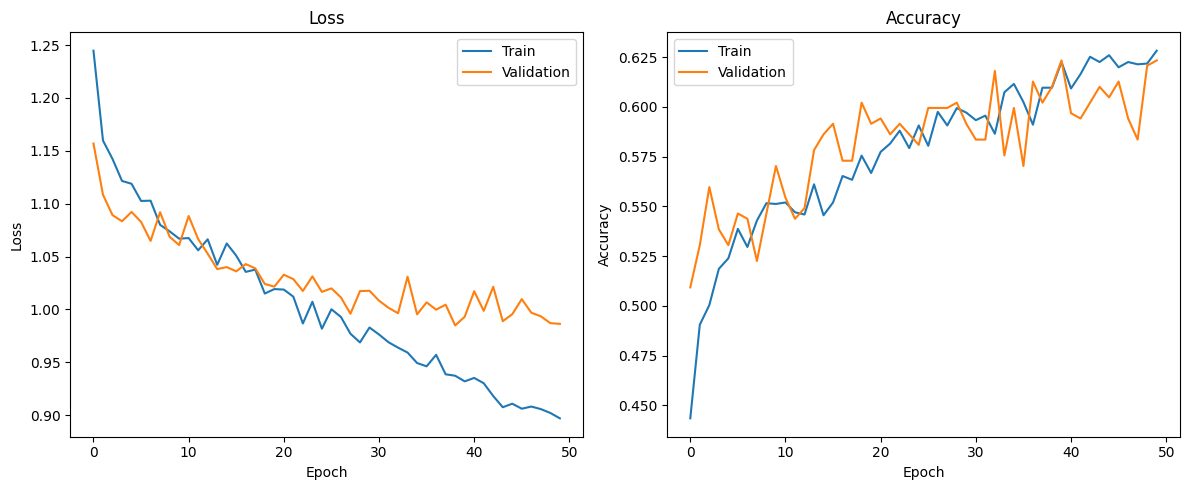

In [11]:
# Initialize the classifier
classifier = CricketShotClassifier(config_path)

# Function to train the model
def train_model(train_path, val_path, output_dir, model_name="cricket_shot_classifier.pt"):
    # Load data
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    
    # Load class mapping
    class_mapping_path = os.path.join(os.path.dirname(train_path), "class_mapping.json")
    classifier.load_class_mapping(class_mapping_path)
    
    # Prepare data
    X_train, y_train, X_val, y_val = classifier.prepare_data(
        train_df, val_df, label_col='class', sequence_length=1  # For image data
    )
    
    # Build model
    input_size = X_train.shape[2]  # Number of features
    num_classes = len(np.unique(y_train))
    
    model = classifier.build_model(input_size, num_classes)
    
    # Train model (only pass required parameters)
    history = classifier.train(X_train, y_train, X_val, y_val)
    
    # Save model
    os.makedirs(output_dir, exist_ok=True)
    model_path = os.path.join(output_dir, model_name)
    classifier.save_model(model_path)
    
    print(f"Model saved to {model_path}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_history.png"))
    plt.show()
    
    return model_path

# Train the model
splits_dir = os.path.join(features_dir, "splits")
train_path = os.path.join(splits_dir, "train.csv")
val_path = os.path.join(splits_dir, "val.csv")

print("Starting model training...")
model_path = train_model(train_path, val_path, models_dir)

## 7. Model Evaluation

Let's evaluate the trained model on the test set to see how well it performs on unseen cricket shot images.

Evaluating model on test set...
Classification Report:
{'drive': {'precision': 0.8205128205128205, 'recall': 0.5079365079365079, 'f1-score': 0.6274509803921569, 'support': 189.0}, 'legglance-flick': {'precision': 0.5714285714285714, 'recall': 0.5263157894736842, 'f1-score': 0.547945205479452, 'support': 190.0}, 'pullshot': {'precision': 0.5597014925373134, 'recall': 0.7575757575757576, 'f1-score': 0.6437768240343348, 'support': 198.0}, 'sweep': {'precision': 0.6237113402061856, 'recall': 0.6836158192090396, 'f1-score': 0.6522911051212938, 'support': 177.0}, 'accuracy': 0.6193633952254642, 'macro avg': {'precision': 0.6438385561712228, 'recall': 0.6188609685487473, 'f1-score': 0.6178660287568094, 'support': 754.0}, 'weighted avg': {'precision': 0.6430585601952713, 'recall': 0.6193633952254642, 'f1-score': 0.6175346964197359, 'support': 754.0}}


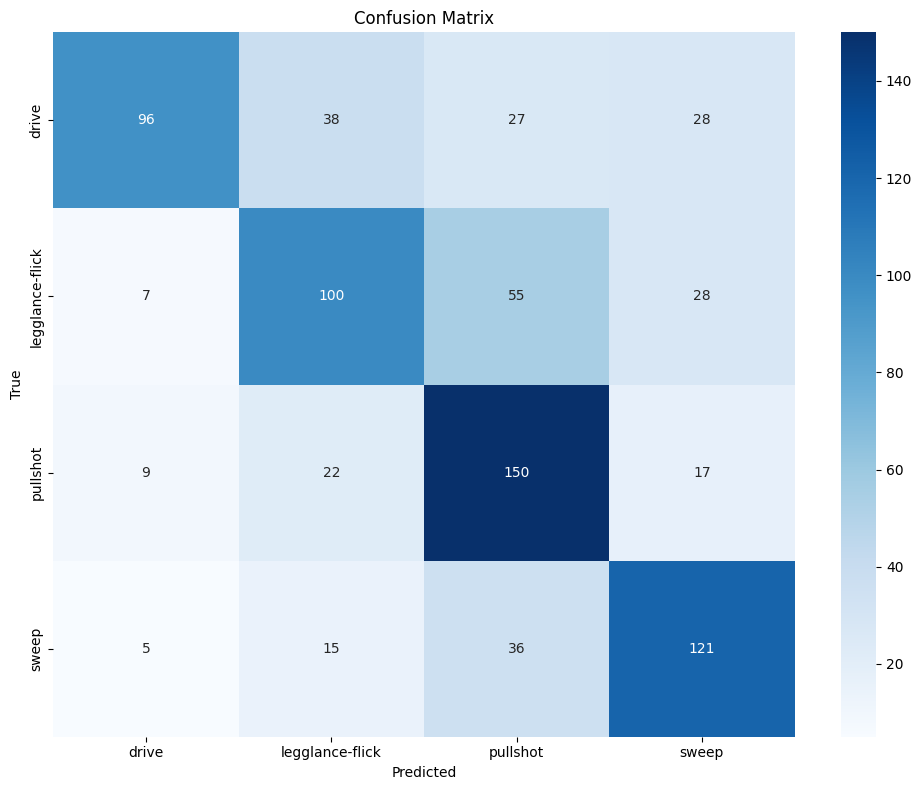

In [12]:
# Function to evaluate the model
def evaluate_model(model_path, test_path):
    # Load model
    classifier = CricketShotClassifier(config_path)
    
    # Load metadata to get input size and num_classes
    metadata_path = Path(model_path).with_suffix('.json')
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        input_size = metadata.get('input_size')
        num_classes = metadata.get('num_classes')
        
        # Fallback: get num_classes from classes if not directly available
        if num_classes is None and 'classes' in metadata:
            num_classes = len(metadata['classes'])
        
        # Load model
        classifier.load_model(model_path, input_size=input_size, num_classes=num_classes)
    else:
        print(f"Warning: No metadata file found at {metadata_path}")
        print("Cannot evaluate model without metadata. Please retrain the model.")
        return
    
    # Load test data
    test_df = pd.read_csv(test_path)
    
    # Prepare test data
    X_test, y_test = classifier.prepare_data(test_df, label_col='class', sequence_length=1)
    
    # Evaluate using the correct method signature
    try:
        results = classifier.evaluate(X_test, y_test)
        
        # Print classification report
        print("Classification Report:")
        print(results['classification_report'])
        
        # Plot confusion matrix
        cm = results['confusion_matrix']
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classifier.label_encoder.classes_,
                    yticklabels=classifier.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(os.path.join(os.path.dirname(model_path), "confusion_matrix.png"))
        plt.show()
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        print("This might be due to:")
        print("1. Model not trained properly")
        print("2. Test data format issues")
        print("3. Missing or incompatible features")

# Evaluate the model
splits_dir = os.path.join(features_dir, "splits")
test_path = os.path.join(splits_dir, "test.csv")

print("Evaluating model on test set...")
evaluate_model(model_path, test_path)

## 8. Making Predictions

Now let's use the trained model to make predictions on new cricket shot images and visualize the results.

Testing predictions with fixed function...

Predicting shot for drives271.png (true class: drive)
Image loaded: (167, 301, 3)
RGB image shape: (167, 301, 3)
MediaPipe results: True
Extracted 6 features, model expects 6


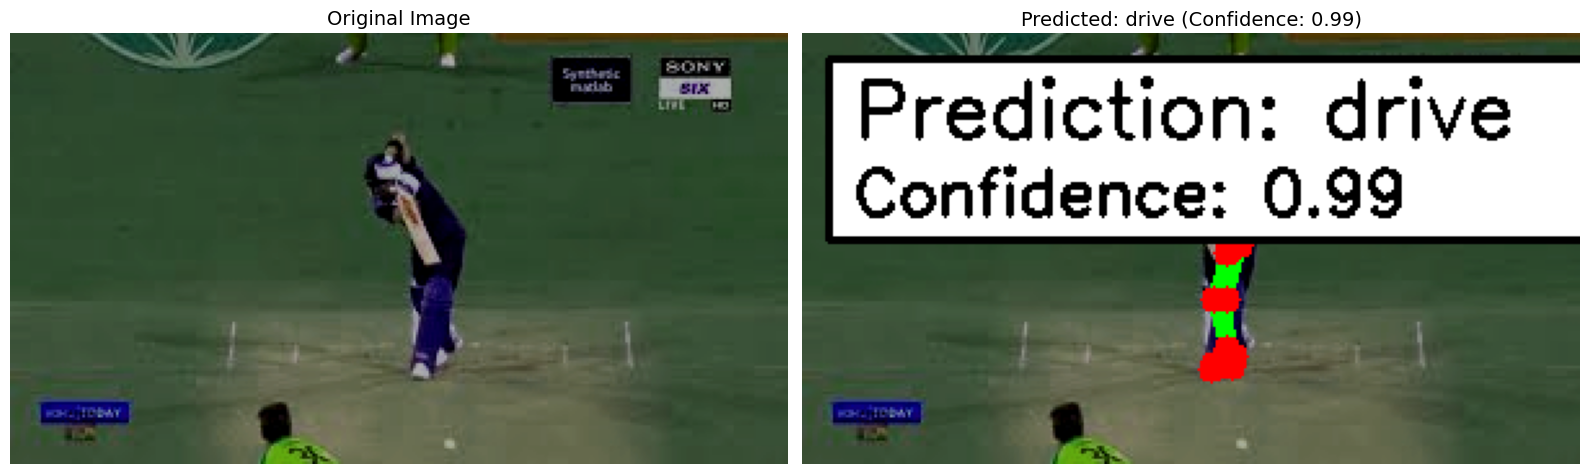

Predicted: drive with confidence 0.99
Correct: True

Predicting shot for legglance94.png (true class: legglance-flick)
Image loaded: (266, 189, 3)
RGB image shape: (266, 189, 3)
MediaPipe results: False
No landmarks detected in ../data\legglance-flick\legglance94.png
No prediction could be made


In [14]:
# Fixed Prediction Function for Cricket Shot Classification
# Copy and paste this into the last cell of your notebook

import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

# Function to predict cricket shot from an image (FIXED VERSION)
def predict_shot(model_path, image_path, visualize=True):
    """
    Predict cricket shot from an image with proper feature handling.
    
    Args:
        model_path (str): Path to the trained model
        image_path (str): Path to the image to predict
        visualize (bool): Whether to show visualization
        
    Returns:
        tuple: (prediction, confidence) or (None, None) if failed
    """
    # Load model
    classifier = CricketShotClassifier(config_path)
    
    # Load metadata to get input size and num_classes
    metadata_path = Path(model_path).with_suffix('.json')
    if not metadata_path.exists():
        print(f"Warning: No metadata file found at {metadata_path}")
        print("Cannot predict without model metadata.")
        return None, None
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    input_size = metadata.get('input_size')
    num_classes = metadata.get('num_classes')
    
    # Fallback: get num_classes from classes if not directly available
    if num_classes is None and 'classes' in metadata:
        num_classes = len(metadata['classes'])
    
    if input_size is None or num_classes is None:
        print("Error: Missing input_size or num_classes in metadata")
        return None, None
    
    # Load model
    try:
        classifier.load_model(model_path, input_size=input_size, num_classes=num_classes)
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None
    
    # Extract pose
    pose_extractor = ImagePoseExtractor(config_path)
    temp_dir = os.path.join(processed_dir, 'temp')
    os.makedirs(temp_dir, exist_ok=True)
    
    try:
        pose_data, pose_path = pose_extractor.process_image(image_path, temp_dir, visualize=False)
        
        if not pose_data['landmarks']:
            print(f"No landmarks detected in {image_path}")
            return None, None
        
        # Calculate features using the same process as training
        angle_calculator = JointAngleCalculator()
        
        # Adapt pose data format for the angle calculator
        adapted_pose_data = {
            'frames': [{
                'frame_idx': 0,
                'timestamp': 0,
                'landmarks': pose_data['landmarks']
            }]
        }
        
        # Create a temporary JSON file
        temp_pose_path = os.path.join(temp_dir, f"temp_{Path(image_path).stem}.json")
        with open(temp_pose_path, 'w') as f:
            json.dump(adapted_pose_data, f)
        
        # Calculate joint angles
        features_df = angle_calculator.process_pose_data(temp_pose_path)
        
        # CRITICAL FIX: Use the same feature preparation as training
        # Get feature columns (exclude metadata columns)
        exclude_cols = ['frame_idx', 'timestamp', 'class']
        feature_cols = [col for col in features_df.columns if col not in exclude_cols]
        
        # Extract only the feature values
        features_array = features_df[feature_cols].values
        
        # Ensure we have the expected number of features
        print(f"Extracted {features_array.shape[1]} features, model expects {input_size}")
        
        if features_array.shape[1] != input_size:
            print(f"Feature mismatch: got {features_array.shape[1]}, expected {input_size}")
            # Try to match the expected input size
            if features_array.shape[1] > input_size:
                features_array = features_array[:, :input_size]
                print(f"Trimmed features to {input_size}")
            else:
                print("Cannot proceed - not enough features")
                return None, None
        
        # Reshape for LSTM input: (batch_size, sequence_length, features)
        X_pred = features_array.reshape(1, 1, input_size)
        
        # Make prediction
        prediction, confidence = classifier.predict(X_pred)
        
        # Clean up temporary files
        if os.path.exists(temp_pose_path):
            os.remove(temp_pose_path)
        
        # Visualize if requested
        if visualize and prediction is not None:
            # Load the original image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Create visualization with pose overlay
            h, w = image.shape[:2]
            overlay_img = image.copy()
            
            # Convert normalized coordinates to pixel coordinates
            landmarks = pose_data['landmarks']
            points = []
            for lm in landmarks:
                x = int(lm['x'] * w)
                y = int(lm['y'] * h)
                points.append((x, y))
            
            # Define MediaPipe pose connections (skeleton)
            mp_pose_connections = [
                (11, 12),  # Shoulders
                (11, 13), (13, 15),  # Left arm
                (12, 14), (14, 16),  # Right arm
                (11, 23), (12, 24),  # Body
                (23, 24),  # Hips
                (23, 25), (25, 27),  # Left leg
                (24, 26), (26, 28),  # Right leg
            ]
            
            # Draw connections
            for connection in mp_pose_connections:
                if connection[0] < len(points) and connection[1] < len(points):
                    pt1 = points[connection[0]]
                    pt2 = points[connection[1]]
                    cv2.line(overlay_img, pt1, pt2, (0, 255, 0), 3)
            
            # Draw landmarks
            for i, point in enumerate(points):
                cv2.circle(overlay_img, point, 5, (255, 0, 0), -1)
            
            # Add prediction text
            font = cv2.FONT_HERSHEY_SIMPLEX
            pred_class = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
            conf_score = confidence[0].max() if hasattr(confidence[0], 'max') else confidence.max()
            
            text = f"Prediction: {pred_class}"
            conf_text = f"Confidence: {conf_score:.2f}"
            
            # Add text background
            cv2.rectangle(overlay_img, (10, 10), (400, 80), (255, 255, 255), -1)
            cv2.rectangle(overlay_img, (10, 10), (400, 80), (0, 0, 0), 2)
            
            # Add text
            cv2.putText(overlay_img, text, (20, 40), font, 1.0, (0, 0, 0), 2)
            cv2.putText(overlay_img, conf_text, (20, 70), font, 0.8, (0, 0, 0), 2)
            
            # Display original and result side by side
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            axes[0].imshow(image)
            axes[0].set_title('Original Image', fontsize=14)
            axes[0].axis('off')
            
            axes[1].imshow(overlay_img)
            axes[1].set_title(f'Predicted: {pred_class} (Confidence: {conf_score:.2f})', fontsize=14)
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return prediction, confidence
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

# Test predictions on sample images
print("Testing predictions with fixed function...")

# Get available shot types
data_dir = "../data"
shot_types = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
model_path = os.path.join(models_dir, "cricket_shot_classifier.pt")

# Test with 2 shot types
for shot_type in shot_types[:2]:
    shot_dir = os.path.join(data_dir, shot_type)
    image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
    
    if image_files:
        # Select a random image
        test_image = np.random.choice(image_files)
        print(f"\nPredicting shot for {os.path.basename(test_image)} (true class: {shot_type})")
        
        prediction, confidence = predict_shot(model_path, test_image)
        
        if prediction is not None:
            pred_class = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
            conf_score = confidence[0].max() if hasattr(confidence[0], 'max') else confidence.max()
            print(f"Predicted: {pred_class} with confidence {conf_score:.2f}")
            print(f"Correct: {pred_class == shot_type}")
        else:
            print("No prediction could be made")

## 9. Conclusion

In this notebook, we've demonstrated the complete workflow for the image-based cricket shot classification system:

1. **Data Exploration**: We explored the dataset of cricket shot images organized by shot type.
2. **Pose Extraction**: We used MediaPipe to extract pose landmarks from cricket shot images.
3. **Feature Engineering**: We calculated joint angles and other biomechanical features from the pose data.
4. **Dataset Preparation**: We prepared the complete dataset for training, processing all 1200+ images per category.
5. **Model Training**: We trained a multiclass LSTM model to classify different cricket shots.
6. **Model Evaluation**: We evaluated the model's performance on the test set.
7. **Making Predictions**: We used the trained model to make predictions on new images.

With the larger dataset, the model should now be much more robust and less prone to overfitting, providing better generalization to new cricket shot images.